In [1]:
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pylab as plt
from scipy.interpolate import interp1d

2023-06-16 14:11:21.523116: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-16 14:11:21.562148: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-16 14:11:21.562992: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-16 14:11:22.318409: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
IMAGE_SIZE = (180,50)

In [3]:
def plot(accuracy, loss, val_accuracy, val_loss):
    """ Function for returning schedule of accuracy and loss
    
    Parameters:
    accuracy (list): result of training
    loss (list): result of training
    val_accuracy (list): result of training
    val_loss (list): result of training
    
    Returns:
    None: -
    """
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('total loss')
    ax1.plot(loss, color='tab:red', label='Training Loss')
    ax1.plot(val_loss, color='tab:brown', label='Validation Loss')
    ax1.tick_params(axis='y')

    ax2 = ax1.twinx()
    ax2.set_ylabel('accuracy')
    ax2.plot(accuracy, color='tab:blue', label='Training Accuracy')
    ax2.plot(val_accuracy, color='tab:green', label='Validation Accuracy')
    ax2.tick_params(axis='y')

    # Combine the legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines = lines1 + lines2
    labels = labels1 + labels2
    ax1.legend(lines, labels, loc='lower right')

    # Set the title
    plt.title('Графік залежностей точності та втрат від кількості Епох')

    fig.tight_layout()
    plt.show()


In [4]:
def plot_smooth(accuracy, loss, val_accuracy, val_loss):
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Total Loss')

    # Smooth the loss and validation loss curves using cubic interpolation
    x = np.arange(len(loss))
    x_smooth = np.linspace(0, len(loss) - 1, 300)
    f_loss = interp1d(x, loss, kind='cubic')
    f_val_loss = interp1d(x, val_loss, kind='cubic')
    loss_smooth = f_loss(x_smooth)
    val_loss_smooth = f_val_loss(x_smooth)

    ax1.plot(x_smooth, loss_smooth, color='tab:red', label='Training Loss')
    ax1.plot(x_smooth, val_loss_smooth, color='tab:brown', label='Validation Loss')
    ax1.tick_params(axis='y')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy')

    # Smooth the accuracy and validation accuracy curves using cubic interpolation
    f_accuracy = interp1d(x, accuracy, kind='cubic')
    f_val_accuracy = interp1d(x, val_accuracy, kind='cubic')
    accuracy_smooth = f_accuracy(x_smooth)
    val_accuracy_smooth = f_val_accuracy(x_smooth)

    ax2.plot(x_smooth, accuracy_smooth, color='tab:blue', label='Training Accuracy')
    ax2.plot(x_smooth, val_accuracy_smooth, color='tab:green', label='Validation Accuracy')
    ax2.tick_params(axis='y')

    # Combine the legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines = lines1 + lines2
    labels = labels1 + labels2
    ax1.legend(lines, labels, loc='lower right')

    # Set the title
    plt.title('Графік залежностей точності та втрат від кількості Епох(менша к-ть даних)')

    fig.tight_layout()
    plt.show()

In [5]:
def show_best_res(list_of_data): # return max value in every list of accuracy
    max_val = {}
    for i, o in enumerate(list_of_data):
        max_val[i] = max(o)
    return dict(sorted(max_val.items(), key=lambda item: item[1], reverse=True))

In [6]:
def create_new_dataset(path):
    images = sorted(os.listdir(path))
    for image in images:
        if 'ipynb_checkpoints' in image:
            continue
        old_path = path + '/' + image
        new_path = f"/home/jovyan/dataset2/dataset2/{image[:3]}"

        if os.path.exists(new_path):
            shutil.copyfile(old_path, new_path+'/'+image)
        else:
            os.mkdir(new_path)
            shutil.copyfile(old_path, new_path+'/'+image)

In [7]:
# data_folder = "/home/jovyan/work/ear/raw"
# create_new_dataset(data_folder)
# train_datagen = "/home/jovyan/dataset2/dataset2"
# splitfolders.ratio(train_datagen, output="/home/jovyan/dataset2/dirty_set", seed=1337, ratio=(.7, 0.3)) 
train_folder = "/home/jovyan/dataset2/train"
test_folder = "/home/jovyan/dataset2/test"

In [8]:
train_datagen = ImageDataGenerator(rescale = 1./255, shear_range=0.2, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale = 1./255)


training_set = train_datagen.flow_from_directory(train_folder,
                                                 target_size = IMAGE_SIZE,
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_folder,
                                            target_size = IMAGE_SIZE,
                                            batch_size = 8,
                                            class_mode = 'categorical')


Found 561 images belonging to 222 classes.
Found 237 images belonging to 222 classes.


In [9]:
def model(in_1=32, in_2=32, in_3=32, in_4=32, in_5=32):
    model = Sequential()
    model.add(Conv2D(filters=in_1,kernel_size=3, strides=1, input_shape=(180,50,3), padding='same', activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    model.add(Conv2D(filters=in_2,kernel_size=3, strides=1, padding = 'same', activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))

    model.add(Conv2D(filters=in_3,kernel_size=3, strides=1, padding ='same', activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))    
    
    model.add(Conv2D(filters=in_4,kernel_size=3, strides=1, padding ='same', activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    model.add(Conv2D(filters=in_5,kernel_size=3, strides=1, padding ='same', activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    model.add(Conv2D(filters=in_4,kernel_size=3, strides=1, padding ='same', activation = 'relu'))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(units = 222, activation = 'softmax'))

    model.compile( optimizer='Adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])

    return model

In [10]:
SAVED_MODEL_BEST_ACCURACY_RESULTS2 = []
SAVED_MODEL_BEST_VAL_ACCURACY_RESULTS2 = []

def final_model():
    ready_model = model()
    #call_back = ModelCheckpoint(f"/home/jovyan/weights.hdf5", monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='auto')
    trained_model = ready_model.fit(training_set, steps_per_epoch = 16 , epochs = 800, #len(training_set)
                                    validation_data = test_set, validation_steps=8)# , callbacks = [call_back]) #len(test_set)
    
    SAVED_MODEL_BEST_ACCURACY_RESULTS2.append(trained_model.history['accuracy'])
    SAVED_MODEL_BEST_VAL_ACCURACY_RESULTS2.append(trained_model.history['val_accuracy'])
    return trained_model, ready_model

history, trained_model = final_model()

Epoch 1/800


2023-06-16 14:11:25.765328: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-16 14:11:27.064266: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 18432000 exceeds 10% of free system memory.
2023-06-16 14:11:27.207383: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 15130368 exceeds 10% of free system memory.
2023-06-16 14:11:27.207448: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 15130368 exceeds 10% of free system memory.
2023-06-16 14:11:27.208622: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 23265792 exceeds 10% of free system memory.
2023-06-16 14:11:27.208691: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 23265792 exceeds 10% of

16/16 [==============================] - ETA: 0s - loss: 5.7784 - accuracy: 0.0117

2023-06-16 14:11:29.278251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


16/16 [==============================] - 4s 151ms/step - loss: 5.7784 - accuracy: 0.0117 - val_loss: 5.4379 - val_accuracy: 0.0000e+00
Epoch 2/800
16/16 [==============================] - 2s 129ms/step - loss: 5.4203 - accuracy: 0.0117 - val_loss: 5.4123 - val_accuracy: 0.0000e+00
Epoch 3/800
16/16 [==============================] - 2s 114ms/step - loss: 5.1626 - accuracy: 0.0290 - val_loss: 5.3885 - val_accuracy: 0.0000e+00
Epoch 4/800
16/16 [==============================] - 2s 105ms/step - loss: 5.1437 - accuracy: 0.0166 - val_loss: 5.3951 - val_accuracy: 0.0156
Epoch 5/800
16/16 [==============================] - 2s 109ms/step - loss: 5.0356 - accuracy: 0.0234 - val_loss: 5.3957 - val_accuracy: 0.0000e+00
Epoch 6/800
16/16 [==============================] - 2s 112ms/step - loss: 4.9629 - accuracy: 0.0124 - val_loss: 5.2491 - val_accuracy: 0.0156
Epoch 7/800
16/16 [==============================] - 2s 115ms/step - loss: 4.8304 - accuracy: 0.0249 - val_loss: 5.0968 - val_accuracy: 0.

sorted list of max  epochs' values for accuracy   {0: 0.8506224155426025}
sorted list of max  epochs' values for val_accuracy   {0: 0.875}


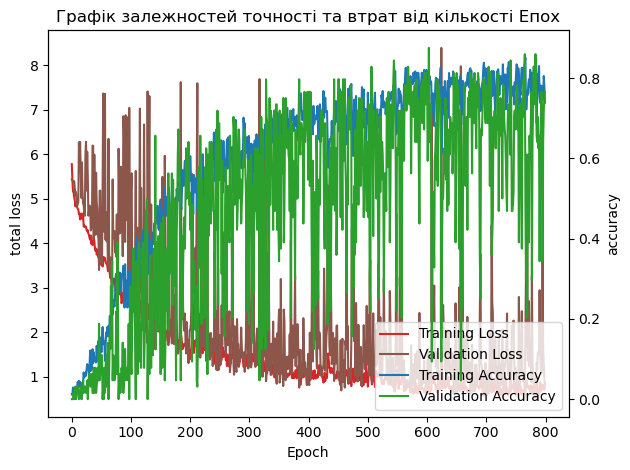

In [11]:
if trained_model:
    print("sorted list of max  epochs' values for accuracy  ", show_best_res(SAVED_MODEL_BEST_ACCURACY_RESULTS2))
    print("sorted list of max  epochs' values for val_accuracy  ", show_best_res(SAVED_MODEL_BEST_VAL_ACCURACY_RESULTS2))
    plot(history.history['accuracy'], history.history['loss'], history.history['val_accuracy'], history.history['val_loss'])

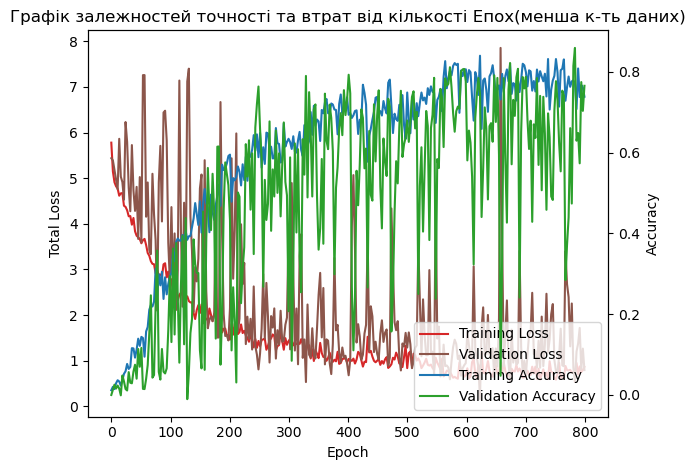

In [12]:
plot_smooth(history.history['accuracy'], history.history['loss'], history.history['val_accuracy'], history.history['val_loss'])